## News Data Exploratory Data Analysis

This notebook performs exploratory data analysis (EDA) on the financial news dataset (row_data_analyst_ratings.csv) to understand the structure, patterns, and insights from news headlines, publishers, and publication dates.

### Setup and Data Loading

Load the necessary libraries and the news dataset, converting the date column to datetime for time-based analysis.

In [1]:
# Download NLTK resources
import nltk
import os

# Define a custom nltk_data path (e.g., inside your project)
nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
os.makedirs(nltk_data_path, exist_ok=True)

# Set the NLTK data path manually
nltk.data.path.append(nltk_data_path)

# Now download the required data to this directory
nltk.download('punkt', download_dir=nltk_data_path, quiet=True)
nltk.download('stopwords', download_dir=nltk_data_path, quiet=True)



# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re


# Function to load news data

def load_news_data(file_path):
    """
    Load and preprocess news data.
    """
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce', utc=True)
    return df

# Load the news data   
news_data = load_news_data('../data/raw_analyst_ratings.csv')




## Basic Descriptive Statistics

Examine the dataset's structure, check for missing values, and analyze headline lengths.

=== Dataset Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype              
---  ------      --------------    -----              
 0   Unnamed: 0  1407328 non-null  int64              
 1   headline    1407328 non-null  object             
 2   url         1407328 non-null  object             
 3   publisher   1407328 non-null  object             
 4   date        1407328 non-null  datetime64[ns, UTC]
 5   stock       1407328 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 64.4+ MB
None

=== Missing Values ===
Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

=== Headline Length Statistics ===
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+0

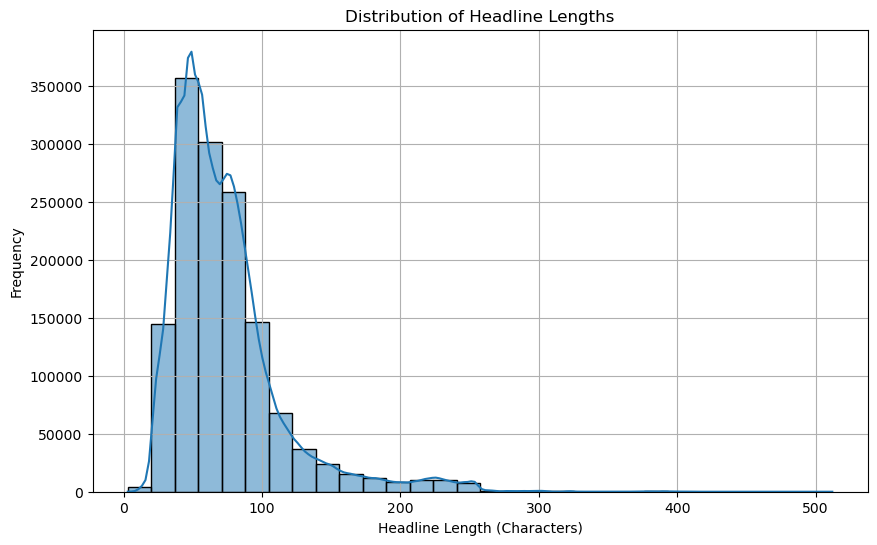

In [2]:
# Display dataset info
print('=== Dataset Overview ===')
print(news_data.info())

# Check for missing values
print('\n=== Missing Values ===')
print(news_data.isnull().sum())

#print(news_data[news_data['date'].isnull()].head(5))
#print(news_data.head())

#df_raw = pd.read_csv('../data/raw_analyst_ratings.csv')
#print(df_raw['date'].dropna().sample(10).tolist())

# Calculate headline length

news_data['headline_length'] = news_data['headline'].apply(len)
print('\n=== Headline Length Statistics ===')
print(news_data['headline_length'].describe())

# Plot headline length distribution
plt.figure(figsize=(10, 6))
sns.histplot(news_data['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length (Characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('../data/processed/headline_length_distribution.png')
plt.show()


### Publisher Analysis

Analyze the distribution of articles by publisher and extract domains from email-based publishers.


=== Top 5 Publishers ===
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64

=== Top 5 Publisher Domains ===
publisher_domain
N/A               1399240
benzinga.com         7937
gmail.com             139
andyswan.com            5
investdiva.com          2
Name: count, dtype: int64


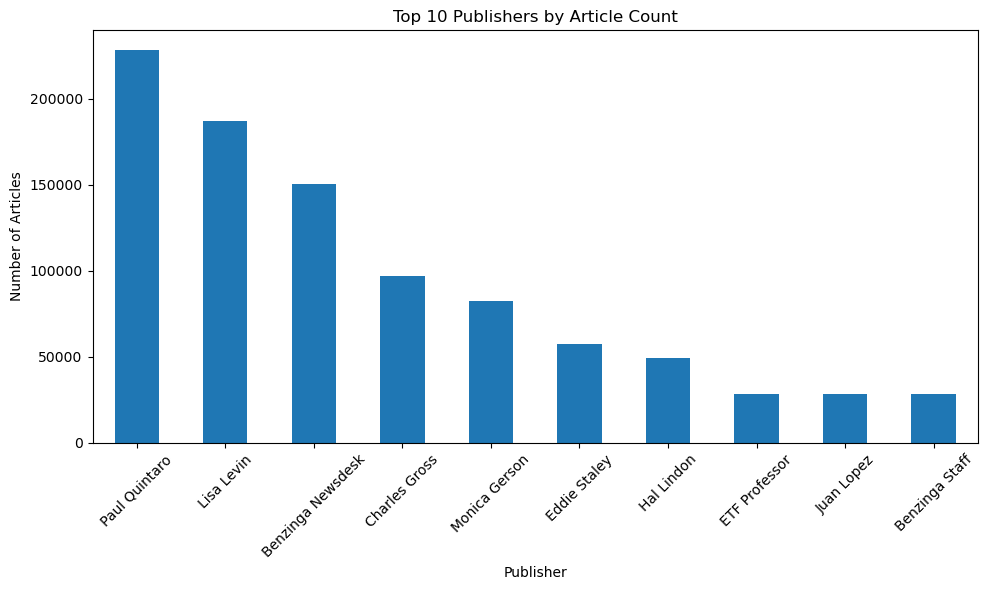

In [3]:
# Function to extract domain from publisher
def extract_domain(publisher):
    """Extract domain from publisher email or return 'N/A' if not an email."""
    if '@' in str(publisher):
        return publisher.split('@')[-1]
    return 'N/A'

# Extract publisher domains
news_data['publisher_domain'] = news_data['publisher'].apply(extract_domain)
publisher_counts = news_data['publisher'].value_counts()
domain_counts = news_data['publisher_domain'].value_counts()

# Display top publishers and domains
print('\n=== Top 5 Publishers ===')
print(publisher_counts.head())
print('\n=== Top 5 Publisher Domains ===')
print(domain_counts.head())

# Plot top publishers
plt.figure(figsize=(10, 6))
publisher_counts[:10].plot(kind='bar')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../data/processed/publisher_distribution.png')
plt.show()

### Time Series Analysis

Analyze publication frequency over time and by hour of the day to identify trends and patterns.

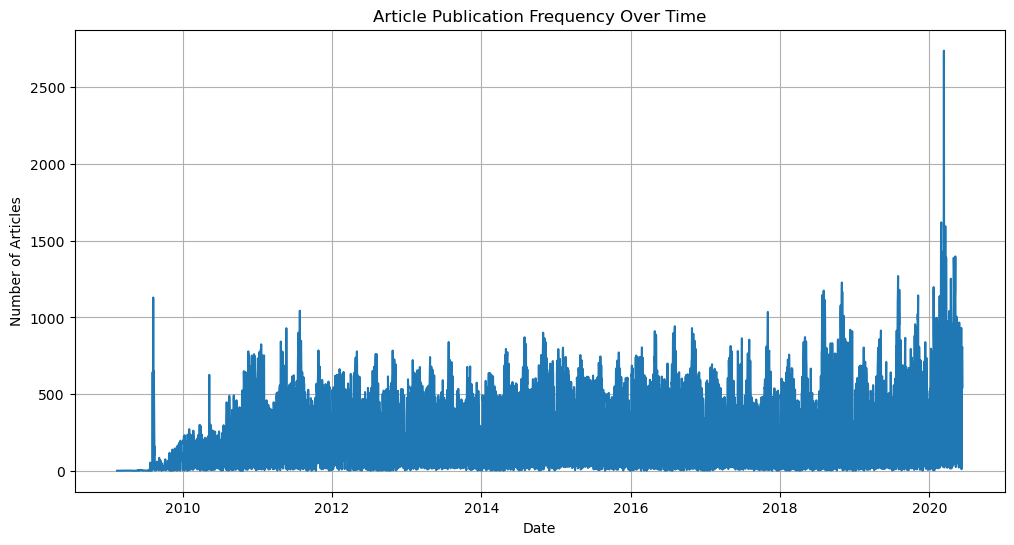

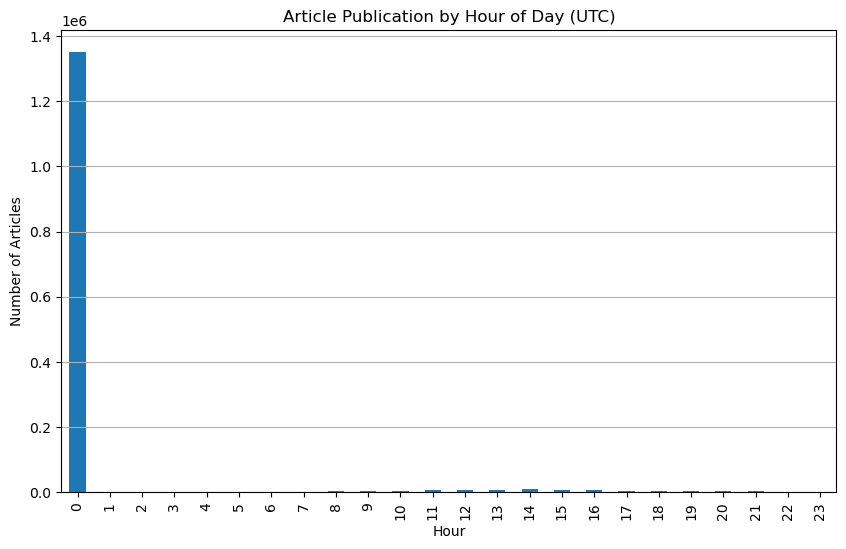

In [4]:
# Extract date and hour
news_data['date_only'] = news_data['date'].dt.date
news_data['hour'] = news_data['date'].dt.hour

# Daily publication frequency
daily_counts = news_data.groupby('date_only').size()
plt.figure(figsize=(12, 6))
daily_counts.plot()
plt.title('Article Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.savefig('../data/processed/publication_frequency.png')
plt.show()

# Hourly publication patterns
hourly_counts = news_data.groupby('hour').size()
plt.figure(figsize=(10, 6))
hourly_counts.plot(kind='bar')
plt.title('Article Publication by Hour of Day (UTC)')
plt.xlabel('Hour')
plt.ylabel('Number of Articles')
plt.grid(axis='y')
plt.savefig('../data/processed/hourly_publication.png')
plt.show()

### Text Analysis (Keyword Extraction)

Extract and analyze common keywords in headlines to identify frequent topics or events.

NLTK data setup complete.

=== Top 10 Keywords in Headlines ===
stocks      161702
vs          138835
eps         128801
est         122289
shares      114140
reports     108688
update       91645
market       91080
earnings     87183
sales        79528
dtype: int64


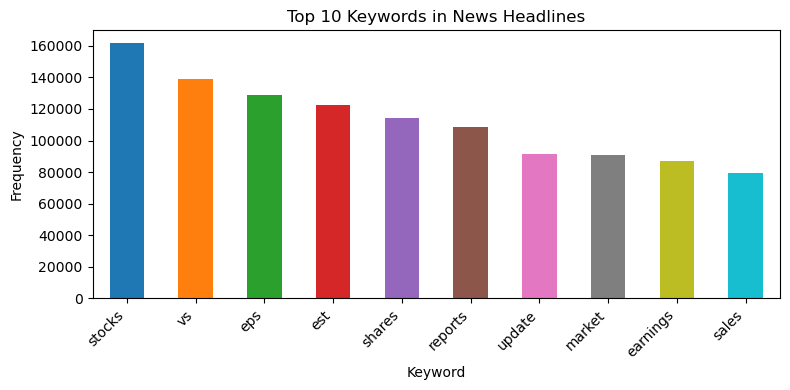

In [5]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Set NLTK data path to existing directory
nltk_data_path = './nltk_data'
os.makedirs(nltk_data_path, exist_ok=True)  # Create directory if it doesn't exist
nltk.data.path.append(nltk_data_path)

# Verify and download NLTK data if necessary
def setup_nltk_data():
    """Verify NLTK data exists and download if missing."""
    required_data = ['tokenizers/punkt_tab', 'corpora/stopwords']
    for data in required_data:
        try:
            nltk.data.find(data)
        except LookupError:
            print(f"Downloading NLTK {data.split('/')[-1]} to {nltk_data_path}...")
            nltk.download(data.split('/')[-1], download_dir=nltk_data_path, quiet=True)
    print("NLTK data setup complete.")

# Run NLTK data setup
setup_nltk_data()

# Optimized keyword extraction
def extract_keywords(text):
    """Extract keywords efficiently, excluding stopwords."""
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    return [word for word in words if word.isalnum() and word not in stop_words]

# Process data in chunks to reduce memory usage
def process_keywords_in_chunks(news_data, chunk_size=1000):
    """Process keywords in chunks to optimize memory usage."""
    all_keywords = []
    for start in range(0, len(news_data), chunk_size):
        chunk = news_data[start:start + chunk_size]
        keywords = chunk['headline'].apply(extract_keywords)
        all_keywords.extend([word for keywords_list in keywords for word in keywords_list])
    return Counter(all_keywords)

try:
    # Ensure news_data exists (replace with your actual DataFrame)
    # Example: news_data = pd.DataFrame({'headline': ['Tech company launches AI', 'AI revolution in healthcare', 'Tech trends in 2025']})
    if 'news_data' not in globals() or 'headline' not in news_data.columns:
        raise NameError("news_data DataFrame with 'headline' column is not defined")

    # Process keywords in chunks
    keyword_counts = process_keywords_in_chunks(news_data, chunk_size=1000)

    # Get top 10 keywords
    top_keywords = pd.Series(keyword_counts).sort_values(ascending=False).head(10)
    print('\n=== Top 10 Keywords in Headlines ===')
    print(top_keywords)

    # Plot top keywords with Matplotlib
    plt.figure(figsize=(8, 4))  # Smaller figure size for performance
    top_keywords.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                                        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
    plt.title('Top 10 Keywords in News Headlines')
    plt.xlabel('Keyword')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Ensure output directory exists
    os.makedirs('../data/processed', exist_ok=True)
    plt.savefig('../data/processed/keyword_frequency.png', dpi=100)  # Lower DPI for faster saving
    plt.show()
    plt.close()  # Close figure to free memory

except NameError as e:
    print(f"Error: {e}. Please ensure 'news_data' DataFrame is defined with a 'headline' column.")
except LookupError as e:
    print(f"NLTK resource error: {e}. Please ensure 'punkt_tab' and 'stopwords' are downloaded to {nltk_data_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

### Stock Symbol Distribution

Analyze the distribution of articles by stock symbol to understand news coverage.


=== Top 5 Stocks by Article Count ===
stock
MRK     3333
MS      3238
NVDA    3146
MU      3142
QQQ     3106
Name: count, dtype: int64


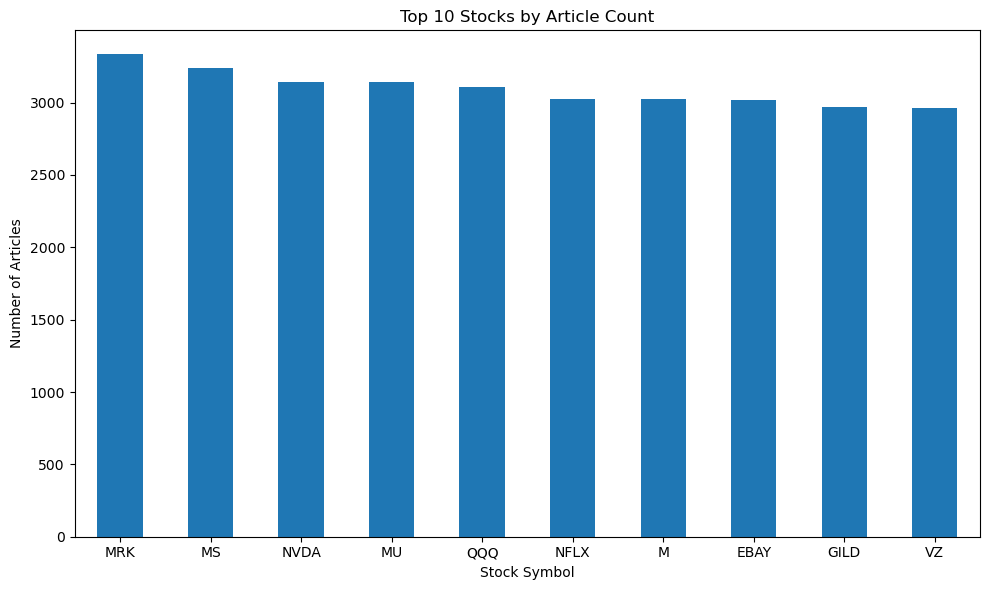

In [24]:
# Stock symbol distribution
stock_counts = news_data['stock'].value_counts()
print('\n=== Top 5 Stocks by Article Count ===')
print(stock_counts.head())

# Plot stock distribution
plt.figure(figsize=(10, 6))
stock_counts[:10].plot(kind='bar')
plt.title('Top 10 Stocks by Article Count')
plt.xlabel('Stock Symbol')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../data/processed/stock_distribution.png')
plt.show()